In [4]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy import distance
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

OSError: Could not find lib c or load any of its variants [].

In [2]:
data_dir = os.getcwd() + '/yelp_dataset'

def load_dataset(data_dir, file):
    df = pd.DataFrame([])
    data_chunk = pd.read_json(os.path.join(data_dir, file), lines=True, chunksize=100000)
    for chunk in data_chunk:
          df = pd.concat([df, chunk])
    return df

print('Loading business data ...')
df_business = load_dataset(data_dir, 'business.json')
print('Loading checkin data ...')
df_checkin = load_dataset(data_dir, 'checkin.json')
print('Loading review data ...')
df_review = load_dataset(data_dir, 'review.json')
print('Loading tip data ...')
df_tip = load_dataset(data_dir, 'tip.json')
print('Loading user data ...')
df_user = load_dataset(data_dir, 'user.json')
print('All datasets have been loaded!')

Loading business data ...
Loading checkin data ...
Loading review data ...
Loading tip data ...
Loading user data ...
All datasets have been loaded!


In [3]:
df_business.groupby('is_open').count()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state
is_open,,,,,,,,,,,,,
0,34084,31021,34084,34063,34084,21713,34084,34084,34084,34084,34084,34084,34084
1,158525,132752,158525,158064,158525,126066,158525,158525,158525,158525,158525,158525,158525


In [4]:
df_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [ ]:
def business_clustering(df):
    print("Clustering business according to Geo-coordinates ...")
    """
    DBSCAN - Density-Based Spatial Clustering of Applications with Noise
    """
    coords = df[['latitude', 'longitude']].values
    # radius of the earth in km
    kms_per_radian = 6371
    # the minimus distance between two restruants is 50m
    epsilon = .05 / kms_per_radian
    # perform clustering
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    df['coords_cluster_label'] = cluster_labels
    # number of resturants in each cluster
    counts_cluster = [len(cluster) for cluster in clusters]
    df['neigbors'] = [counts_cluster[i] for i in cluster_labels]
    
    return df

df_business = business_clustering(df_business)

In [5]:
def checkin_features(df):
    print('Extracting checkin features...')
    checkin = df['date'].values
    checkin_split = list(map(lambda x: x.split(','), checkin))
    # extract 1st and last checkin time
    checkin_start = np.array([pd.Timestamp(i[0]) for i in checkin_split])
    checkin_stop = np.array([pd.Timestamp(i[-1]) for i in checkin_split])
    # get duration of checkin 
    checkin_duration = checkin_stop - checkin_start
    df['checkin_duration'] = [item/pd.Timedelta(days=365.25) for item in checkin_duration]
    # extract 1st and last checkin year and month
    df['checkin_start_year'] = list(map(lambda x: x.year, checkin_start))
    df['checkin_start_month'] = list(map(lambda x: x.month, checkin_start))
    df['checkin_latest_year'] = list(map(lambda x: x.year, checkin_stop))
    df['checkin_latest_month'] = list(map(lambda x: x.month, checkin_stop))
    # get number of checkins
    df['checkin_counts'] = list(map(lambda x: len(x), checkin_split))
    print('Checkin features have been extracted!')
    
    return df

df_checkin = checkin_features(df_checkin)

Extracting checkin features...
Checkin features have been extracted!


In [28]:
df_business_checkin = df_business.merge(df_checkin, on='business_id', how='inner').drop(columns=['date'])
df_business_checkin.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,checkin_duration,checkin_start_year,checkin_start_month,checkin_latest_year,checkin_latest_month,checkin_counts
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ,4.005644,2012,6,2016,6,20
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,8.348187,2010,7,2018,11,455
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,7.993641,2010,11,2018,11,721
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ,3.491028,2012,10,2016,4,11
4,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,4.142462,2014,3,2018,5,3


In [34]:
df_business.pivot_table(index=['name', 'business_id']).head(100)

is_open  \
name                                        business_id                       
 L & A Insurance Services                   FWNoYwndpV88gYAxpjsYTQ        1   
"T"s Hair Affair                            aIq4Qxwr14JeQWYqbc5-5g        1   
# 1 Nails                                   bXf05rPb8HVKRz62L4esww        1   
# 1 Transmission Shop and Auto Repair       fxeW4uUINGEzx_HLJpGbDA        1   
#1 Cochran Buick GMC of Monroeville         7qi90SOzSjf3vfvXfdklCQ        1   
#1 Cochran Buick GMC of Robinson            OVcEKE97K2l3glHZ9YPgNA        1   
#1 Cochran Cadillac - Monroeville           IxzYgn2qvvP-6v2vseAsRw        1   
                                            Z5kqhmXlKA_SDamQ5qwNGA        1   
#1 Cochran Hyundai - Monroeville            tqEQd2LD0DeAqkE9tbZ7zA        1   
#1 Cochran Hyundai of South Hills           1kHRZGYwMSLTxqN4DKcQyQ        1   
#1 Cochran Kia - Robinson                   bTzhVdmvW5ynQgKkcoQOGw        1   
#1 Cochran Mazda - Monroeville              GVSuvjB0Y-td4_Gx4p8yQg        1   
#1 Cochran Mazda - North Hills              YP-BWp7YkJtZnVOeOpVrrA        1   
#1 Cochran Monroeville Collision Center     -AFMB0nVx0kVlbi73ir0Tw        1   
#1 Cochran Nissan - Pittsburgh              6JRFtzzJUYZxFC7mWa9_xQ        1   
#1 Cochran Nissan Monroeville               nGfbNYazqceRrHVys_70zQ        1   
#1 Cochran Subaru                           ZF3WDK3n5orlCDDBzHy-og        1   
#1 Cochran Volkswagen of South Hills        ceYdHEzsk16VhPVrvTg-wQ        1   
#1 Elite Nails                              MURC4bzsScVVIhg7XdsHhg        1   
#1 Fried Rice                               ysaGG0hm7-ug-IuRd-8_ew        0   
#1 Hawaiian Barbecue                        42yLya7lhe7TQGz3KEdKAw        1   
                                            gA78_OGp1ekMvZWjRoBmFw        1   
#1 Nails                                    YIh59OhCJl5lA4Arzi-vbw        1   
#1 Pho                                      AhD9x2NNFqPvVwmyEZU5Cg        0   
#1 Sushi                                    kkEqZmVvVkgmCaOqE13mDg        1   
#1Brothers Pizza                            4z-QW_f3RwCAxHB5fd58TA        1   
$10 Tickets                                 y7FyXJK69II4VaSqSOj6EA        0   
$100 Substance Abuse Evaluation             6qhVDbpuYWJ9GBXEHr9I7A        0   
$2 Shoes                                    wCSxEFuxPvh11_Vy1puIqQ        1   
$2.50 Cleaners                              M6tJmFTCxKtKR2Ye3okEyA        0   
...                                                                     ...   
1 Pot                                       XxmFwrJk1DljL7sLXS1zrQ        1   
1 Reef                                      fkg4MlNnbUVAZ6kuV3AgNw        0   
1 STOP Banner printing                      mwaUTlAwEjBEVYVuBsJnXQ        1   
1 Stop Cleaning Services                    Dv7DWQdr1PjJgbZeFsaSdg        1   
1 Stop Harleys                              _cCzBUqUW2Ub6T5dT2Oo6g        1   
1 Stop Motor Vehicle Services               YQMFA-wJhGQCdvrETlx38w        1   
1 Stop Title Loans                          ZCtUyj4Zikm-Nzi3qRzHBQ        1   
1 Stop Title Loans & Motor Vehicle Services h_tbg0FX1VVSpUWTp-iHUg        1   
1 Touch Towing                              3Jwp9N-BUHu3CuSg6hQTMw        1   
1 World Medicine                            qYVOl60Fb5u67ZsqpfIp0w        0   
1 on 1 Technologies                         dQbGVw-m1LJUrcRTq9RDLQ        1   
1-2-3 Automotive                            IX-aiZ-EIgkg8n7n0srduw        1   
1-800 WATER DAMAGE of Phoenix               HvxYeJERLBvd89xvn7Er0Q        1   
1-800-4A-Gunsafe                            c5ofWMrCEnHG8syvShO4eg        1   
1-800-Flowers                               IIMdSZKA27MK03OAdeVvtA        1   
                                            gPgE8Mrkskj5TnI_I7Ll3A        1   
                                            l79ACsMSAzueI7d0gff6cg        0   
                                            wUxIJ-C7veJ_TAVuSCjA-Q        1   
1-800-GOT-JUNK? Arizona Central        

In [41]:
df_business.pivot_table(index=['name', 'city', 'state', 'business_id'])

is_open  \
name                                    city                state business_id                       
 L & A Insurance Services               Phoenix             AZ    FWNoYwndpV88gYAxpjsYTQ        1   
"T"s Hair Affair                        Chandler            AZ    aIq4Qxwr14JeQWYqbc5-5g        1   
# 1 Nails                               Las Vegas           NV    bXf05rPb8HVKRz62L4esww        1   
# 1 Transmission Shop and Auto Repair   Las Vegas           NV    fxeW4uUINGEzx_HLJpGbDA        1   
#1 Cochran Buick GMC of Monroeville     Monroeville         PA    7qi90SOzSjf3vfvXfdklCQ        1   
#1 Cochran Buick GMC of Robinson        Pittsburgh          PA    OVcEKE97K2l3glHZ9YPgNA        1   
#1 Cochran Cadillac - Monroeville       Monreoville         PA    Z5kqhmXlKA_SDamQ5qwNGA        1   
                                        Monroeville         PA    IxzYgn2qvvP-6v2vseAsRw        1   
#1 Cochran Hyundai - Monroeville        Monroeville         PA    tqEQd2LD0DeAqkE9tbZ7zA        1   
#1 Cochran Hyundai of South Hills       Pittsburgh          PA    1kHRZGYwMSLTxqN4DKcQyQ        1   
#1 Cochran Kia - Robinson               Pittsburgh          PA    bTzhVdmvW5ynQgKkcoQOGw        1   
#1 Cochran Mazda - Monroeville          Monroeville         PA    GVSuvjB0Y-td4_Gx4p8yQg        1   
#1 Cochran Mazda - North Hills          Wexford             PA    YP-BWp7YkJtZnVOeOpVrrA        1   
#1 Cochran Monroeville Collision Center Monroeville         PA    -AFMB0nVx0kVlbi73ir0Tw        1   
#1 Cochran Nissan - Pittsburgh          Pittsburgh          PA    6JRFtzzJUYZxFC7mWa9_xQ        1   
#1 Cochran Nissan Monroeville           Pittsburgh          PA    nGfbNYazqceRrHVys_70zQ        1   
#1 Cochran Subaru                       Monroeville         PA    ZF3WDK3n5orlCDDBzHy-og        1   
#1 Cochran Volkswagen of South Hills    Pittsburgh          PA    ceYdHEzsk16VhPVrvTg-wQ        1   
#1 Elite Nails                          Mesa                AZ    MURC4bzsScVVIhg7XdsHhg        1   
#1 Fried Rice                           Tolleson            AZ    ysaGG0hm7-ug-IuRd-8_ew        0   
#1 Hawaiian Barbecue                    Las Vegas           NV    42yLya7lhe7TQGz3KEdKAw        1   
                                                                  gA78_OGp1ekMvZWjRoBmFw        1   
#1 Nails                                Champaign           IL    YIh59OhCJl5lA4Arzi-vbw        1   
#1 Pho                                  Middleburg Heights  OH    AhD9x2NNFqPvVwmyEZU5Cg        0   
#1 Sushi                                Phoenix             AZ    kkEqZmVvVkgmCaOqE13mDg        1   
#1Brothers Pizza                        Surprise            AZ    4z-QW_f3RwCAxHB5fd58TA        1   
$10 Tickets                             Las Vegas           NV    y7FyXJK69II4VaSqSOj6EA        0   
$100 Substance Abuse Evaluation         Glendale            AZ    6qhVDbpuYWJ9GBXEHr9I7A        0   
$2 Shoes                                Las Vegas           NV    wCSxEFuxPvh11_Vy1puIqQ        1   
$2.50 Cleaners                          Las Vegas           NV    M6tJmFTCxKtKR2Ye3okEyA        0   
...                                                                                           ...   
Épicerie Mile-End                       Montréal            QC    HbY3KqSWRJXJaMrRwZ8qJg        1   
Épicerie Unique - Le Dépôt De La Biére  Montréal            QC    BypY_sJ__Mm2k4xZWnL4Sw        1   
Épices Anatol                           Montréal            QC    S4PeUUV6YCzfiZ8rVtwYAw        1   
Épices de Cru                           Montréal            QC    -mF_pjHDweFE3kh8yiMatw        1   
Érablière Charbonneau                   Mont-Saint-Grégoire QC    eJzrAbHQKeDPk7juIWsRGg        1   
Érablière à la Feuille d'Érable         Mont-Saint-Grégoire QC    O3njN4whACQZqPDrgRgdjw        1   
État-Major                              Montréal            QC    jfOyDJ-W4lV47Y61pPcMfQ        1   
Étoile Rouge                            Montréal  

In [39]:
df_business[['name', 'city', 'state']].groupby('name').count()

,city,state
name,,
L & A Insurance Services,1,1
"""T""s Hair Affair",1,1
# 1 Nails,1,1
# 1 Transmission Shop and Auto Repair,1,1
#1 Cochran Buick GMC of Monroeville,1,1
#1 Cochran Buick GMC of Robinson,1,1
#1 Cochran Cadillac - Monroeville,2,2
#1 Cochran Hyundai - Monroeville,1,1
#1 Cochran Hyundai of South Hills,1,1


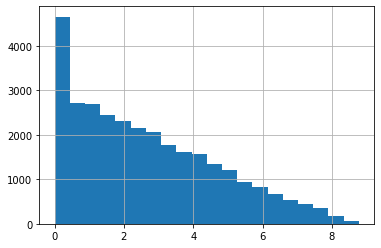

In [98]:
df_new[df_new['is_open']==0]['checkin_duration'].hist(bins=20)
plt.show()

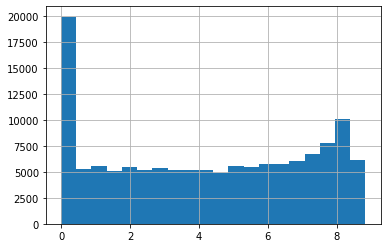

In [99]:
df_new[df_new['is_open']==1]['checkin_duration'].hist(bins=20)
plt.show()

In [25]:
df_checkin.head()

,business_id,date,checkin_duration,checkin_start_year,checkin_start_month,checkin_latest_year,checkin_latest_month,checkin_counts
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...",1.018269,2016,4,2017,5,6
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...",7.381770,2011,6,2018,10,167
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015...",3.868873,2014,12,2018,11,180
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30,0.000000,2016,7,2016,7,1
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010...",7.975556,2010,6,2018,6,37


In [107]:
df_user.columns

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful',
       'user_id', 'yelping_since'],
      dtype='object')

In [10]:
df_tip.head()

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg
2,5KheTjYPu1HcQzQFtm4_vw,0,2011-12-26 01:46:17,Good chips and salsa. Loud at times. Good serv...,jRyO2V1pA4CdVVqCIOPc1Q
3,TkoyGi8J7YFjA6SbaRzrxg,0,2014-03-23 21:32:49,The setting and decoration here is amazing. Co...,FuTJWFYm4UKqewaosss1KA
4,AkL6Ous6A1atZejfZXn1Bg,0,2012-10-06 00:19:27,Molly is definately taking a picture with Sant...,LUlKtaM3nXd-E4N4uOk_fQ
